## For Colabs

In [1]:
!pip install pycm livelossplot

In [3]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (420/420), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 420 (delta 218), reused 291 (delta 114), pack-reused 0
Receiving objects: 100% (420/420), 4.03 MiB | 24.69 MiB/s, done.
Resolving deltas: 100% (218/218), done.


In [128]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Mounted at /content/gdrive/


In [5]:
import os
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")
os.listdir()

['Models',
 '.DS_Store',
 'Data',
 '.ipynb_checkpoints',
 'ARIMA_Model.ipynb',
 '__pycache__',
 'Gaussian_Process.ipynb',
 'utils.py',
 'LSTM.ipynb',
 'Additive_Model.ipynb',
 'Chai_Base.ipynb',
 'deeplearning.py',
 'preprocessing.py',
 'test.py',
 '.idea',
 'db_access.py']

## Loading Packages

In [6]:
from deeplearning import *
from livelossplot import PlotLosses
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from preprocessing import *
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

True

### Insuring that training is done on GPU if available

In [7]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Loading Data

In [0]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "Cu")

## Preprocessing

In [9]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Lg Returns Only
# df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)

# Price Only
df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [0]:
# Both Price and Log Returns
# df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=False)

In [0]:
# # Raw Price Target
# df_target = df_full[["price_cu_lme"]]
# df_target = df_target.shift(-5)

# # # df_full = df_full[df_full.columns.drop(list(df_full.filter(regex='price')))]
# df_full[["target"]] = df_target

The target column represents the log returns at one forecast length out in the future for the instrument of interest (aluminium or copper prices on the London Metals Exchange). 

To normalise the independent variables, the 1 day log returns between closing prices have been used.

In [0]:
# Visualise the plots
# visualise_universe(universe_dict)
df_full = df_full[["price_cu_lme"]]
# df_full = df_full[["cu_lme"]]

In [10]:
df_full.head(15)
# df_full.tail(5)

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci
date,,,,,,,,,,,
2006-09-13,69540.0,7484.5,3.3925,15748.0,537.35,3.2530,4129.0,4.901,11.18,120.44,438.38855
2006-09-14,71350.0,7439.0,3.3820,14180.0,537.73,3.2475,4207.0,4.926,11.55,119.47,433.72522
2006-09-15,69400.0,7281.0,3.3165,14775.0,537.10,3.2480,4258.0,4.939,11.76,135.25,431.58291
2006-09-18,69830.0,7459.0,3.4180,15263.0,537.10,3.2450,4279.0,4.949,11.78,127.35,434.97293
2006-09-19,71470.0,7516.0,3.3755,17523.0,537.10,3.2450,4275.0,4.948,11.98,125.03,426.51240
2006-09-20,69610.0,7474.0,3.3700,18091.0,537.80,3.2450,4244.0,4.937,11.39,122.71,418.32234
2006-09-21,70170.0,7602.0,3.4220,19546.0,539.70,3.2480,4200.0,4.921,12.25,119.68,423.56908
2006-09-22,71170.0,7601.0,3.4395,20627.0,538.50,3.2470,4136.0,4.924,12.59,118.86,418.01647
2006-09-25,71130.0,7560.0,3.4475,20978.0,539.30,3.2490,4069.0,4.907,12.12,120.75,418.93144


In [68]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_full)
scaled_data.shape

(3333, 11)

In [0]:
scaled_target = scaled_data[:, df_full.columns.get_loc('price_cu_lme')]
# scaled_target = scaled_data[:, df_full.columns.get_loc('cu_lme')]
# Need to remove final 5 values in df
scaled_target = shift(scaled_target, -5)

In [0]:
scaled_data = scaled_data[:-5, :]
scaled_target = scaled_target[:-5]

In [0]:
dataset_size = 1500

scaled_data = scaled_data[:dataset_size, :]
scaled_target = scaled_target[:dataset_size]

In [72]:
print(scaled_data.shape)
print(scaled_target.shape)

# print(scaled_data[:10, 1])
# print(scaled_target[:10])

(1500, 11)
(1500,)


### PCA

In [67]:
thresh = 0.95

for n_dim in range(1, 11):
    pca = PCA(n_components=n_dim)
    pca.fit(scaled_data)

    if sum(pca.explained_variance_ratio_) > thresh:
        print("Number of dimensions:", n_dim, 
             sum(pca.explained_variance_ratio_))
    else: print("No", sum(pca.explained_variance_ratio_))

No 0.43425379765361916
No 0.8358757769399348
No 0.931406203233768
Number of dimensions: 4 0.9565865437689408
Number of dimensions: 5 0.9701937896803973
Number of dimensions: 6 0.9822148234684126
Number of dimensions: 7 0.99029985996799
Number of dimensions: 8 0.9949622748931334
Number of dimensions: 9 0.9981499248146981
Number of dimensions: 10 0.9999297052498892


In [73]:
# Reducing the dataset to containing a threshold 
# amount of variance
# n_dim = dimension_selector(df_X, thresh=0.98)
# df_X = dimension_reduce(df_X, n_dim)
# print(scaled_data.shape)
pca = PCA(n_components=4)
scaled_data = pca.fit_transform(scaled_data)
print(sum(pca.explained_variance_ratio_), pca.explained_variance_ratio_)

[0.4342538  0.40162198 0.09553043 0.02518034]


### Chunking Series into Windows

In [74]:
# The input size of each time series window
series_length = 60

# Creating a data structure which is slices of input size
data_X = []
data_y = []

# For prototyping
# length = int(len(df_X)/10)
length = len(scaled_data)

for i in range(series_length, length):
    data_X.append(scaled_data[i-series_length:i, :])
    data_y.append(scaled_target[i])
    
data_X, data_y = np.array(data_X), np.array(data_y)

print(data_X.shape, data_y.shape)

(1440, 60, 4) (1440,)


### Class for LSTM deep learning

In [0]:
class DeepLearning():
    """Class to perform training and validation for a given model
    :param
    model: nn.Module the model to be trained
    df_X
    df_y
    n_epochs,
    optimiser, 
    window_size,
    loss_function
    device
    seed=42
    debug
    """
    def __init__(self, model, data_X, data_y,
                 n_epochs,
                 optimiser, 
                 window_size,
                 loss_function=torch.nn.MSELoss(size_average=False),
                 device="cpu", 
                 seed=42,
                 debug = True, 
                 disp_freq=20,
                 fig_disp_freq=50):
        
        
        # The neural network architecture
        self.model = model
        
        # The optimiser for gradient descent
        self.optimiser = optimiser
        
        # Dataframe of training values
        self.data_X = data_X
        
        # Dataframe of target values
        self.data_y = data_y
        
        # The number of epochs
        self.n_epochs = n_epochs
   
        #self.optimiser = optimiser
        self.loss_function = loss_function
        
        # Whether to run on cpu or gpu
        self.device = device
        
        # The random seed to set
        self.seed = seed
        
        # To activate debug mode
        self.debug = debug
        
        # For training/val logs
        self.logs = {}
        
        # The array of predicted lists for each batch
        self.pred_list = None
        
        # The data
        self.X_train = None
        self.X_val = None
        self.X_test = None
        
        # The targets
        self.y_train = None
        self.y_val = None
        self.y_test = None
        
        # The length of the time series window
        self.window_size = window_size
        
        # How frequently the loss is printed
        self.disp_freq = disp_freq
        
        # How frequently a figure is plotted
        self.fig_disp_freq = fig_disp_freq
        
        # Storing the best model
        self.best_model = None
        
        # Dummy variable for inspecting quantities
        self.inspect = None
        
        # For running dataloaders on CUDA
        self.pin_memory = False
        
        
    def train_val_test(self):
        """Splits the dataframes in to a training, validation
        and test set and creates torch tensors from the underlying
        numpy arrays"""
        # Splitting the sets into train, test and validation
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data_X, self.data_y, test_size=0.2, shuffle=False)
        
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.25, shuffle=False)

        if self.debug:
            print("Train Length: \t\t%i\nValidation Length: \t%i\nTest Length:\t\t%i" 
                  % (len(X_train), len(X_val), len(X_test)))
        
        # Tensor of training data
        self.X_train = torch.from_numpy(self.X_train).float()
        self.y_train = torch.from_numpy(self.y_train).float()

        # Tensor of training labels
        self.X_val = torch.from_numpy(self.X_val).float()
        self.y_val = torch.from_numpy(self.y_val).float()

        #  Tensor of test data
        self.X_test = torch.from_numpy(self.X_test).float()
        self.y_test = torch.from_numpy(self.y_test).float()

        # Size Check
        if self.debug:
            print("\nInitial Size Check:")
            self.size_check()
    
    
    def size_check(self):
        """Checks the size of the datasets"""
        if self.debug:
            print("\nX Train Shape:\t\t", self.X_train.size())
            print("X Val Shape:\t\t", self.X_val.size())
            print("X Test Shape:\t\t", self.X_test.size())

            print("\ny Train Shape:\t\t", self.y_train.size())
            print("y Val Shape:\t\t", self.y_val.size())
            print("y Test Shape:\t\t", self.y_test.size())

        
    
    def create_data_loaders(self):
        """Forms iterators to pipeline in the data"""
            
        # Create tensor datasets
        train_dataset = TensorDataset(self.X_train, self.y_train)
        val_dataset = TensorDataset(self.X_val, self.y_val)
        test_dataset = TensorDataset(self.X_test, self.y_test)
        
        if self.device =='cuda': self.pin_memory=True
          
        # Data loaders
        train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
        val_data_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
        test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8,  pin_memory=self.pin_memory)
        
        return train_data_loader, val_data_loader, test_data_loader
    
    
    def train(self, train_data_loader):
        """Performs a single training cycle and returns the
        mean squared error loss for the training dataset"""
        # Sets the model to train mode
        self.model.train()
        
        train_loss = 0.
        
        # List of each batch predictions
        pred_list = []
        
        # The data loader creates batches of data to train
        for i_batch, (X_train_batch, y_train_batch) in enumerate(train_data_loader):
            
            #print('Batch : ', i_batch)
            
            # Sending the data to GPU if available
            X_train_batch = X_train_batch.to(self.device)
            y_train_batch = y_train_batch.to(self.device)
            
            # Zeros the gradients
            self.optimiser.zero_grad()

            # Need to set seed here to make deterministic
            set_seed(42)
        
            # Perform forward pass
            y_pred = self.model(X_train_batch)
            
            # Calculate loss for the batch
            loss = self.loss_function(y_pred, y_train_batch)   

            # Perform backward pass
            loss.backward()   

            # Adding the predictions for this batch to prediction list
            pred_list.append(y_pred)
            
            # Calculate the training loss
            train_loss += (loss * X_train_batch.size()[0]).detach().cpu().numpy()

            # Update Parameters
            self.optimiser.step()               
        
        # Converting an array of batches of predictions to a list of predictions
        self.pred_list = [single_pred for batch in pred_list for single_pred in batch.detach().cpu().numpy()]
        
        return train_loss/len(train_data_loader.dataset.tensors[0])
    
    
    def validate(self, val_data_loader):
        """Evaluates the performance of the network
        on unseen validation data"""
        # Set the model to evaluate mode
        self.model.eval()
        
        val_loss = 0.
        # The data loader creates batches of data to validate
        for X_val_batch, y_val_batch in val_data_loader:
            
            # Ensures that the gradients are not updated
            with torch.no_grad():
                
                # Sending the data to GPU if available
                X_val_batch = X_val_batch.to(self.device)
                y_val_batch = y_val_batch.to(self.device)

                # Perform forward pass
                y_pred = self.model(X_val_batch)

                # Calculate loss for the batch
                loss = self.loss_function(y_pred, y_val_batch) 
                
                # Calculate the validation loss
                val_loss += (loss * X_val_batch.size()[0]).detach().cpu().numpy()
            
        return val_loss/len(val_data_loader.dataset.tensors[0])
    
    
    def live_pred_plot(self):
#         x_axis = np.array(range(len(self.pred_list)))
        plt.plot(self.pred_list, label="Predicted")
        plt.plot(self.y_train.numpy(), label="Observed")
        plt.legend()
        plt.show()
    
    def training_wrapper(self):
        
        # start timer
        start_time = time.time()

        # set seed
        set_seed(int(self.seed))
        
        # Create data loaders
        train_loader, val_loader, test_loader = learning.create_data_loaders()
        
        # Shows live plot of losses
        liveloss = PlotLosses()
        
        train_log = []
        val_log = []
        
        # The best validation score tracker
        self.best_val_score = np.inf
        
        # Begin training
        for epoch in range(self.n_epochs):
            
            live_logs = {}
            
            train_loss = self.train(train_loader) 
            val_loss = self.validate(val_loader) 
            
            # Saving the best model
            if val_loss < self.best_val_score:
                self.best_model = self.model
                self.best_val_score = val_loss.item()
                
            # For live plotting
            live_logs['' + 'log loss'] = train_loss.item()
            live_logs['val_' + 'log loss'] = val_loss.item()
            live_logs['time'] = time.time() - start_time
            #liveloss.update(self.logs)
            #liveloss.draw()
            
            train_log.append(train_loss.item())
            val_log.append(val_loss.item())
            self.logs["Training Loss"] = train_log
            self.logs["Validation Loss"] = val_log
            
            if (epoch % self.disp_freq == 0): 
                print("Epoch: %i Train MSE: %.5f Val MSE: %.5f  Time: %.3f" % (epoch, train_loss.item(),
                                                          val_loss.item(), (time.time() - start_time)))
                
            if (epoch % self.fig_disp_freq == 0):
                self.live_pred_plot()

In [0]:
class LSTM(nn.Module):
    """A Long Short Term Memory network
    model"""
        
    def __init__(self, num_features, hidden_dim, output_dim,
                 batch_size, series_length, 
                 dropout=0.1, num_layers=2, debug=True):
        
        super(LSTM, self).__init__()
        
        # Number of features
        self.num_features = num_features
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers
        
        # The output dimensions
        self.output_dim = output_dim
        
        # Batch Size
        self.batch_size = batch_size
        
        # Length of sequence
        self.series_length = series_length
        
        # Dropout Probability
        self.dropout = dropout
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size = self.num_features, 
            hidden_size =self.hidden_dim,
            dropout = self.dropout ,
            num_layers =self.num_layers)

        # Fully Connected Layer
        self.fc1 = nn.Linear(in_features=self.hidden_dim, 
                             out_features=self.hidden_dim)
        
        # Activation function
        self.act = nn.ReLU()
        
        # Output layer
        self.out = nn.Linear(in_features=self.hidden_dim, 
                             out_features=self.output_dim)
        
        """TODO Add fully connected layer and see if that improves"""
        
        
    def init_hidden(self, batch_size):
        """Initialised the hidden state to be zeros"""
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))
    
    
    def forward(self, x):
        """Forward pass through the neural network"""
        
        """TODO Directly switch these variables in 
        the permute of the dataset"""
        
        # Adjust to a variable batch size 
        batch_size = x.size()[0]
        series_length = x.size()[1]
        
        #print("series_length, batch_size", series_length, batch_size)

        assert (series_length == self.series_length)
        
        """TODO Check output of contiguous and non 
        contigious memory"""
        
        # Keeps the dimensions constant regardless of batchsize
        x = x.contiguous().view(series_length, batch_size, -1) 

        # Initialises the hidden states
        h0, c0 = self.init_hidden(batch_size)
        
        # Pass through through lstm layer
        # Only the x is of interest
        x, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Output is seq to seq but only want seq to val
        # So only use the final value of the lstm outputted
        # sequence
        x = x[-1]  
        
        # Fully connected hidden layer
        x = self.act(self.fc1(x))
        
        return self.out(x).view(-1)

### Hyperparameters

In [0]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32
test_batch_size = 1000
# series_length = 100

n_epochs = 5

# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 128
num_layers = 2
output_dim = 1

### Initialising the model

In [76]:
model_lstm = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim, 
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers)

model_lstm.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 4 
hidden_dim 128
series_length 60 
batch_size 32
output_dim 1 
num_layers 2
data_X  (1440, 60, 4) 
data_y (1440,)


Epoch: 0 Train MSE: 10.37108 Val MSE: 11.32928  Time: 1.937


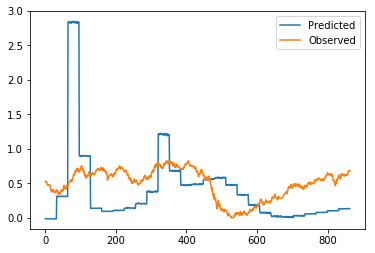

Epoch: 10 Train MSE: 2.24980 Val MSE: 3.82634  Time: 20.635


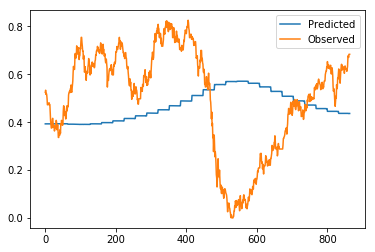

Epoch: 20 Train MSE: 1.76338 Val MSE: 3.14400  Time: 39.378


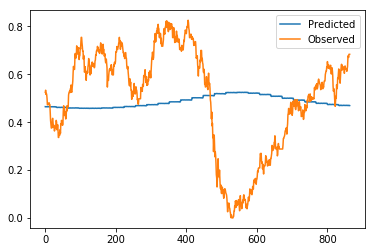

Epoch: 30 Train MSE: 1.64339 Val MSE: 2.81997  Time: 58.212


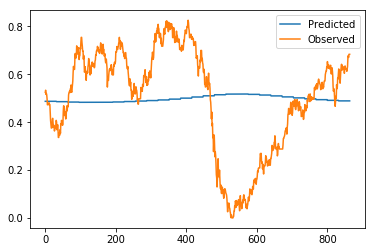

Epoch: 40 Train MSE: 1.64614 Val MSE: 2.82102  Time: 76.864


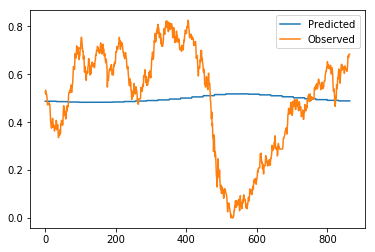

KeyboardInterrupt: ignored

In [77]:
optimiser = torch.optim.Adam(model_lstm.parameters(), learning_rate)
# optimizer = optim.RMSprop(model_lstm.parameters(), lr=learning_rate, weight_decay=0.0)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model_lstm, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=2000,
                        optimiser=optimiser,
                        window_size=series_length,
                        debug=False, 
                        disp_freq=10,
                        fig_disp_freq=10, 
                        device=device)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

In [0]:
model_save(model_lstm, name="LSTM", val_score=learning.best_val_score)

mod = model_load(path="Models/",
           model_name="LSTM_5_854")

### Plotting

In [101]:
# min(learning.logs['Training Loss'])
min(learning.logs['Validation Loss'])
# len(learning.logs['Training Loss'])

'2_269'

In [0]:
predicted = learning.pred_list
observed = learning.y_train.numpy()

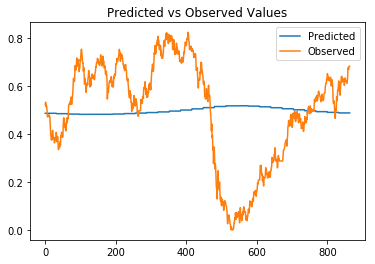

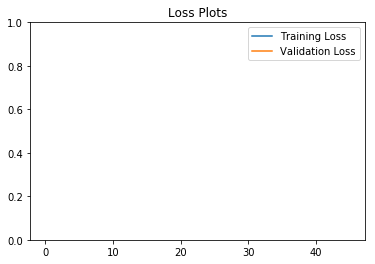

In [80]:
plt.title("Predicted vs Observed Values")
plt.plot(predicted, label="Predicted")
plt.plot(observed, label="Observed")
plt.legend()
plt.show()

plt.figure()
plt.title("Loss Plots")
plt.plot(learning.logs['Training Loss'], label="Training Loss")
plt.plot(learning.logs['Validation Loss'], label="Validation Loss")
plt.legend()
plt.ylim((0,1))

epoch_reached = len(learning.logs['Training Loss'])
val_min = min(learning.logs['Validation Loss'])

plt.savefig("LSTM:, ", val_min, epoch_reached)
plt.show()

In [91]:
data_X.shape

(1440, 60, 4)

In [148]:
def param_strip(param):
    """Strips the key text info out of certain parameters"""
    return str(param)[:str(param).find('(')]
  
num_epoch = 90
PCA = True
data_X_shape = data_X.shape
train_loss = 0.02
val_loss = 0.03
test_loss  = 0.1
train_time = 900
  
row = [param_strip(model_lstm),
       param_strip(optimiser),
       num_epoch, 
       learning_rate, 
       momentum,
       weight_decay, 
       PCA, 
       data_X_shape,
       train_loss,
       val_loss, 
       test_loss,
       train_time]

ind = ["param_strip(model_lstm)",
       "param_strip(optimiser)",
       "num_epoch", 
       'learning_rate', 
       "momentum",
       "weight_decay", 
       "PCA", 
       "data_X_shape",
       "train_loss",
       "val_loss", 
       "test_loss",
       "train_time"]


def full_save(model, name_tag, path="Models/"):
  """Saves the models weights and hyperparameters to a pth file and csv file"""
#   ind = ["Model, Optimiser, Loss Function, Early Stop Tol, Epochs, Learning Rate, Momentum, Weight Decay, nFolds, Augmentations, Val Acc, Val Loss, Training Time, Test Acc"]
  
  ind = ["param_strip(model_lstm)",
       "param_strip(optimiser)",
       "num_epoch", 
       'learning_rate', 
       "momentum",
       "weight_decay", 
       "PCA", 
       "data_X_shape",
       "train_loss",
       "val_loss", 
       "test_loss",
       "train_time"]
  
  model_name = param_strip(model_lstm)
  
  row = [model_name,
       param_strip(optimiser),
       num_epoch, 
       learning_rate, 
       momentum,
       weight_decay, 
       PCA, 
       data_X_shape,
       train_loss,
       val_loss, 
       test_loss,
       train_time]
  
  s = [str(i) for i in row] 
  
  ind = [",".join(s)]
  row = [",".join(s)]
         
  model_save(model, name="LSTM", val_score=val_loss)

  np.savetxt(path + name_tag + '_' + str(val_loss).replace(".", "_")[:5] + ".csv", np.r_[ind, row], fmt='%s', delimiter=',')
  return



full_save(model = model_lstm, 
          name_tag = "Trial")

NameError: ignored

In [142]:
os.listdir("Models")

['.DS_Store', 'LSTM_5_854.pth']

### Plotting

### Data for a toy case

In [0]:
# batch_size = 40
batch_size = 80

In [0]:
X_train = torch.load('Data/Examples/X_train.pt').permute(1, 0, 2)
X_test = torch.load('Data/Examples/X_test.pt').permute(1, 0, 2)
y_train = torch.load('Data/Examples/y_train.pt')
y_test = torch.load('Data/Examples/y_test.pt')

y_train = y_train + 10
y_test = y_test + 10

In [0]:
print(X_train.shape)
# 80 series, 20 is the length of a series, 1 feature

# X_train [number of series, length of series, feature number]
# y_train [number of series]

torch.Size([80, 20, 1])


In [0]:
dset = TensorDataset(X_train, y_train)

In [0]:
train_loader = DataLoader(dset,
                          batch_size=batch_size,
                          shuffle=False)

In [0]:
model_toy = LSTM(num_features=1, 
             hidden_dim=64, 
             batch_size=batch_size,
             output_dim=1, 
             num_layers=2, 
             series_length=20)

model_toy = model_toy.to(device)

Epoch: 0 MSE: 0.05505 Time: 0.051


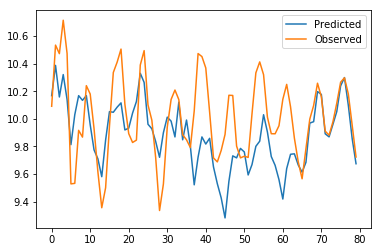

Epoch: 100 MSE: 0.02178 Time: 4.323
Epoch: 200 MSE: 0.00946 Time: 8.369


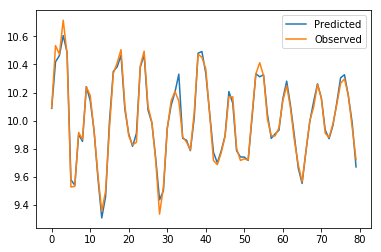

KeyboardInterrupt: ignored

In [0]:
num_epochs = 10000

log = np.zeros(num_epochs)
loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 1e-3
optimiser = torch.optim.Adam(model_toy.parameters(), learning_rate)

observed_list = []
start_time = time.time()


def plot_pred_obs(predicted, observed_list):
    x_axis = np.array(range(len(predicted)))
    observed = [single_pred for batch in observed_list for single_pred in batch.detach().cpu().numpy()]

    plt.plot(x_axis, np.array(predicted), label="Predicted")
    plt.plot(x_axis, observed, label="Observed")
    plt.legend()
    plt.show()
    
    
for epoch in range(num_epochs):
    
    predicted = []
    
    for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):
        
        
        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)
        
        if epoch == 0: observed_list.append(y_train_batch)
            
        # Zero out gradients
        optimiser.zero_grad()
        
        # Need to set seed here to make deterministic
        set_seed(42)
        
        # Forward pass
        y_pred = model_toy(X_train_batch)
        
        # Adding the predicted values to a list for plotting
        for pred_ix in range(y_pred.size()[0]):
            predicted.append(y_pred[pred_ix].item())

        # Loss Function
        loss = loss_fn(y_pred, y_train_batch)
        log[epoch] = loss.item()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    if epoch % 100 == 0: print("Epoch: %i MSE: %.5f Time: %.3f" % (epoch, loss.item(), (time.time() - start_time)))
        
    if epoch % 200.0 == 0: plot_pred_obs(predicted, observed_list)

# Results

In [0]:
df = df_full[["target"]]
# Taking t-1 to be the value for t
df["persistance"] = df.shift(1)
df.dropna(inplace=True)
# Calculating metrics for these columns
MSE, MAE, MDE = evaluate(df, "target", "persistance")

In [0]:
print(df[:5])
print(df[-5:])

              target  persistance
date                             
2006-09-14  0.021675    -0.001404
2006-09-15  0.043012     0.021675
2006-09-18  0.013450     0.043012
2006-09-19  0.025225     0.013450
2006-09-20  0.024843     0.025225
              target  persistance
date                             
2019-06-24 -0.000589     0.004104
2019-06-25 -0.026401    -0.000589
2019-06-26 -0.010480    -0.026401
2019-06-27 -0.011358    -0.010480
2019-06-28 -0.015457    -0.011358


In [0]:
# Placing in results dataframe
results = pd.DataFrame(columns={"MSE", "MAE", "MDE"})
results.index.name = 'Name'
results.head()
results.loc["persistance"] = [MSE, MAE, MDE] 
results.head()

,MSE,MAE,MDE
Name,,,
persistance,0.000582,0.017105,0.465585
